In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.4 MB/s eta 0:00:00


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Wed Jan 18 08:28:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [3]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

from transformers import pipeline
import more_itertools
from typing import List
from tqdm import tqdm

# If you set the display.max_colwidth option, the information will be displayed fully
pd.set_option('display.max_colwidth', None)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [6]:
DATA_COLUMN = "text"
LABEL_COLUMN = "dialect"

In [9]:
df_dialect = pd.read_csv("/content/drive/MyDrive/CIT_DL_project/downloaded_dataset/dialect_dataset_cleaned.csv")

df_dialect = df_dialect[["text","dialect"]]  # we are interested in text and dialect only
df_dialect.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_dialect[LABEL_COLUMN].value_counts())

label_list_dialect = list(df_dialect[LABEL_COLUMN].unique())
print(label_list_dialect)

train_dialect, test_dialect = train_test_split(df_dialect, test_size=0.1, random_state=42, stratify=df_dialect[LABEL_COLUMN] )

print("Training length: ", len(train_dialect))
print("Testing length: ", len(test_dialect))

data_dialect = CustomDataset("Dialect", train_dialect, test_dialect, label_list_dialect)

EG    57636
KW    42109
PL    40456
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64
['TN', 'YE', 'MA', 'SD', 'IQ', 'DZ', 'SY', 'OM', 'BH', 'AE', 'LB', 'JO', 'SA', 'QA', 'KW', 'EG', 'LY', 'PL']
Training length:  409419
Testing length:  45492


In [10]:
label_map = { v:index for index, v in enumerate(data_dialect.label_list) }
print(label_map)
inv_label_map = { v:k for k, v in label_map.items()}

{'TN': 0, 'YE': 1, 'MA': 2, 'SD': 3, 'IQ': 4, 'DZ': 5, 'SY': 6, 'OM': 7, 'BH': 8, 'AE': 9, 'LB': 10, 'JO': 11, 'SA': 12, 'QA': 13, 'KW': 14, 'EG': 15, 'LY': 16, 'PL': 17}


In [11]:
pred_df = pd.DataFrame([])
pred_df[DATA_COLUMN] = data_dialect.test[DATA_COLUMN].copy()
# max_len = 32

In [12]:
pipe = pipeline("sentiment-analysis", model="/content/drive/MyDrive/CIT_DL_project/arabert_training/output_dir", device=0, return_all_scores =False) # max_length=max_len, truncation=True
preds = []
for s in tqdm(pred_df[DATA_COLUMN].to_list()):
    #print(s)
    preds.append(pipe(str(s))[0]["label"])

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
  0%|          | 6/45492 [00:03<5:52:35,  2.15it/s] /usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 45492/45492 [08:17<00:00, 91.47it/s] 


In [13]:
pred_df["Prediction"] = preds
pred_df

,text,Prediction
69120,رمضان برك ورانا راجعين ليها,DZ
370177,متقولش كنديه دي مصريه دمها مصري وشكلها مصري ربنا يحفظهملك رب,EG
76817,وتقول تفتح التويتر,YE
331670,طلع برنس واحنا اتبطرنا بجد,EG
48157,الجنسيه القطريه عربيه بغل,SD
...,...,...
418828,جمالها ياخد شخصتيها تاخد لذلك,LY
125976,اسلوب دجال وله متابعين يسهل استحمارهم,QA
431430,هه اوك ظلك معتمده عليا اني اصحيكي للامتحان علشان تضمني رسوبك بالماده خلص خلص تغلطيش رح اروح,PL
135258,موسيقي خطوه حبيبي محمد عبد الوهاب,EG


Test accuracy = 0.5658577332278203
              precision    recall  f1-score   support

          TN       0.46      0.48      0.47      2630
          YE       0.36      0.37      0.37      2629
          MA       0.60      0.56      0.58      1618
          SD       0.72      0.87      0.79      5764
          IQ       0.65      0.55      0.59      1550
          DZ       0.46      0.42      0.44      2792
          SY       0.52      0.58      0.55      4211
          OM       0.65      0.69      0.67      2762
          BH       0.73      0.68      0.71      3650
          AE       0.73      0.65      0.69      1154
          LB       0.44      0.42      0.43      1912
          JO       0.55      0.49      0.52      4046
          SA       0.52      0.48      0.50      3107
          QA       0.42      0.52      0.46      2683
          KW       0.74      0.64      0.69      1443
          EG       0.49      0.37      0.42      1624
          LY       0.71      0.49      0.58   

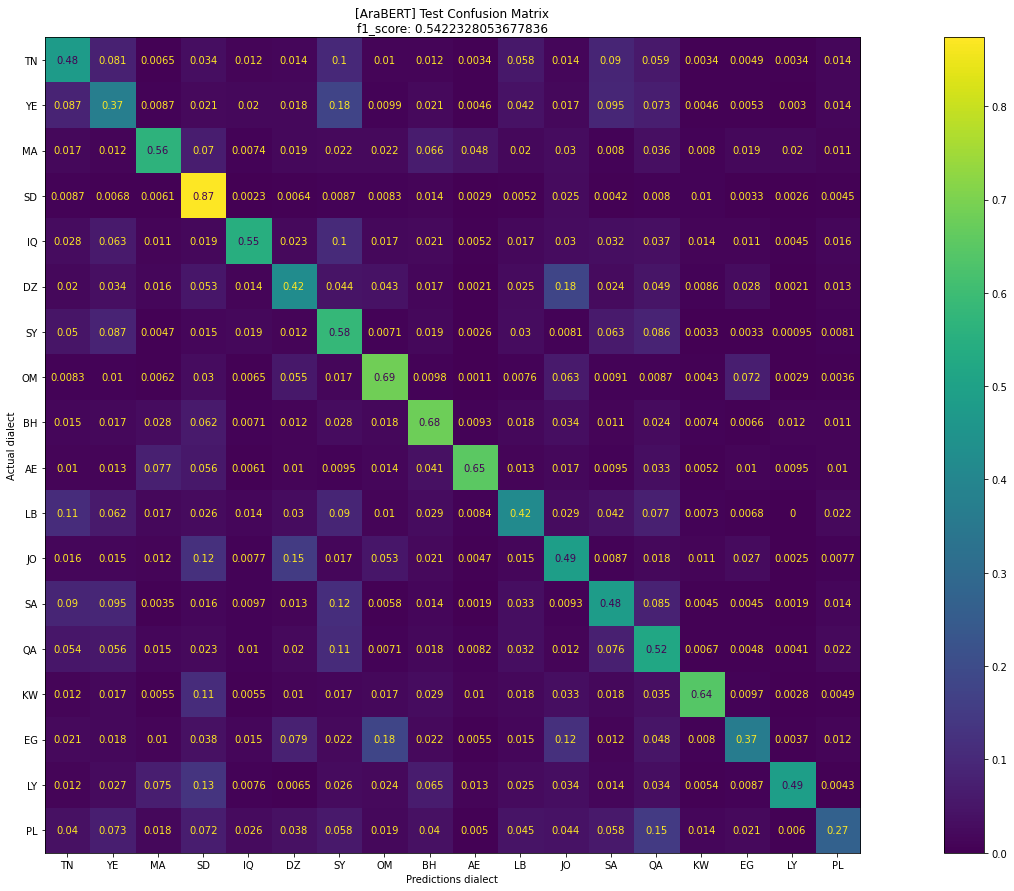

In [14]:
y_test = data_dialect.test[LABEL_COLUMN]
y_test_pred = pred_df["Prediction"]
modelname = "AraBERT"

# Check test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

## Show results
print(classification_report(y_test, y_test_pred, target_names=label_list_dialect))

fig, ax = plt.subplots(1,1,figsize= (30,15))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=label_list_dialect).plot(ax=ax);
ax.set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='macro')}")
ax.set_xlabel('Predictions dialect')
ax.set_ylabel('Actual dialect')
plt.savefig("/content/drive/MyDrive/CIT_DL_project/arabert_training/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
plt.show()